# Generating Fake Tweets

This notebook describes an end-to-end NLP project where I generate fake tweets based on an existing dataset.

For this project I picked a massive dump of Trump's tweets as the dataset is free and availabe [here](https://www.thetrumparchive.com/faq).

**Our objective is to generate believable fake tweets.**

Two models are used in this notebook: Markov Chains and LSTM. These models are trained and empirically evaluated. Markov Chain was able to generate simple, but predictable tweets. Two NN architectures of LSTM were tested. The results showed that both architectures generate better fake tweets than Markov Chains.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("tweets_01-08-2021.csv", index_col="id", parse_dates=['date'])
data.sample(5)

,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
id,,,,,,,,
1205186844276727809,RT @RepAndyBiggsAZ: This President has done a ...,t,f,Twitter for iPhone,0,9291,2019-12-12 18:05:09,f
903778130850131970,"On behalf of @FLOTUS Melania &amp, myself, THA...",f,f,Twitter for iPhone,53160,10516,2017-09-02 00:34:32,f
349858983609249793,"""""""@cloverc8: @realDonaldTrump that's because ...",f,f,Twitter for Android,8,11,2013-06-26 11:57:36,f
1190000118398963713,RT @RepMeuser: Today’s vote on the impeachment...,t,f,Twitter for iPhone,0,8010,2019-10-31 20:18:32,f
1295067207618244610,Thank you James! https://t.co/cKiKlAXHqI,f,f,Twitter for iPhone,104805,15667,2020-08-16 18:37:38,f


In [4]:
data.shape

(56571, 8)

For text generation to be useful, we need to preserve the original words' forms. Thereforem stemming or lemmatization is not needed here. Punctuation might also be useful, so each symbol will be treated as a separate token.

It is a good idea though to remove hyperlinks and convert the dataset to lowercase.

In [5]:
from nltk.tokenize import RegexpTokenizer
import re

text = data.text.to_list()
processed_tweets = []
tokenizer = RegexpTokenizer('\w+|\S+')
for tweet in text:
    tweet = re.sub('(https?:[\w\/\.\d]+)|…|(^RT)|“|”|"', "", tweet)
    tweet = re.sub("&amp;?", "and", tweet)
    processed_tweets.append(tokenizer.tokenize(tweet.lower()))
        

In [6]:
processed_tweets[6]

['getting', 'a', 'little', 'exercise', 'this', 'morning', '!']

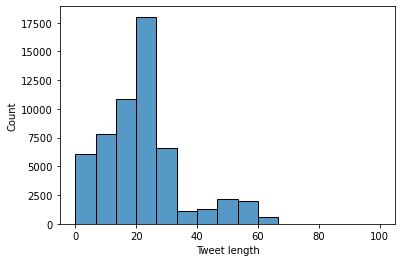

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot([len(tweet) for tweet in processed_tweets], bins=15)
plt.xlabel("Tweet length")
plt.show()

Most of the tweets tend to be of the length 20.

## Markov Chains: Attempt 1

I coded the algorithm from scratch using the [following resource](https://www.kdnuggets.com/2019/11/markov-chains-train-text-generation.html) as a guide. To get a more detailed information on how it works, please refer to my [Medium](https://miroslavtushev.medium.com/generating-fake-trump-tweets-using-markov-chains-d75d9a2eed08) article.

In [8]:
# chains of 2 words
k = 2
# list to hold those chains
sets_of_k_words = []

# create chains with k-length
for tweet in processed_tweets:
    sets_of_k_words.append([' '.join(tweet[i:i+k]) for i, _ in enumerate(tweet[:-k+1])])

from scipy.sparse import dok_matrix
# how many unique chains are there?
distinct_sets_of_k_words = list(set([chain for s in sets_of_k_words for chain in s]))
# how many unique words are there?
distinct_words = list(set([elem for l in processed_tweets for elem in l]))
# sparse matrix: rows - k-length sequence, columns - all possible words in tweets
next_after_k_words_matrix = dok_matrix((len(distinct_sets_of_k_words), len(distinct_words)), dtype=np.uint16)

# to look up the index of a chain (row) for the matrix
k_words_idx_dict = {word: i for i, word in enumerate(distinct_sets_of_k_words)}
# to look up the index of a word (column) for the matrix
word_idx_dict = {word: i for i, word in enumerate(distinct_words)}

# for each sequence go over all tweets and find the next word
# increment the count for that word
for i, set_of_k_words in enumerate(sets_of_k_words):
    for j, k_word in enumerate(set_of_k_words[:-k+1]):
        # index for a row (chain)
        word_sequence_idx = k_words_idx_dict[k_word]
        # get the index for next w
        next_word_idx = word_idx_dict[processed_tweets[i][j+k]]
        next_after_k_words_matrix[word_sequence_idx, next_word_idx] +=1

A simple Markov Chain text generator is completely deterministic in nature. That is, there is not randomness component and the transition to the next state happens according to the highest probability.

In [31]:
# simple case with 0 alpha and fixed length

from scipy.sparse import csr_matrix
from numpy.random import choice

def sample_next_word_after_sequence(word_sequence, alpha = 0):
    next_word_vector = next_after_k_words_matrix[k_words_idx_dict[word_sequence]] + alpha
    likelihoods = csr_matrix(next_word_vector)/next_word_vector.sum()
    weights = likelihoods.toarray().flatten()
    # if no words possible - terminate
    if weights.sum() == 0.0:
        return ""
    return choice(distinct_words, p=weights)
    
def stochastic_chain(seed, chain_length=10, seed_length=k):
    current_words = seed.split(' ')
    if len(current_words) != seed_length:
        raise ValueError(f'wrong number of words, expected {seed_length}')
    sentence = seed

    for _ in range(chain_length):
        sentence += ' '
        next_word = sample_next_word_after_sequence(' '.join(current_words))
        if next_word == "":
            return sentence
        sentence += next_word
        current_words = current_words[1:]+[next_word]
    return sentence

In [32]:
print(stochastic_chain(choice(distinct_sets_of_k_words), chain_length=15))
print(stochastic_chain(choice(distinct_sets_of_k_words), chain_length=10))
print(stochastic_chain(choice(distinct_sets_of_k_words), chain_length=5))

the shit out . borders big problem for which the corrupt new york , doug ! thanks
teamwork and coordination at all times . achievement is not a group
@utennjock: @realdonaldtrump please run . what do


**Problems:**
- The current implementation is deterministic, so there is very little variety in tweets, and common patterns are often appear.
- Periods are not taken into account, so the tweets end abruptly.

# Markov Chains: Attempt 2

Here we are going to address the above-mentioned problems by (a) introducing randomness in the selection of the next state, and (b) adding tweet termination based on the probability of the current length. 

Let's start with the latter. To correctly terminate a generated tweet that looks believable, we are going to generate a CDF of each length probability. Then, when generating a new tweet token by tokn if we encounter a punctuation symbol like *.?!*, we are going to sample the CDF with the probability of terminating the tweet based on the current length.

100


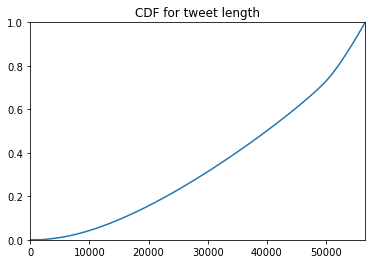

In [11]:
# generating CDF
import matplotlib.pyplot as plt

lens = np.sort([len(tweet) for tweet in processed_tweets])
print(lens[-1])

def gen_prob(val, lens=lens):
    for i, elem in enumerate(lens):
        if elem >= val:
            return i / len(lens)
    return 1.00
 
fig, ax = plt.subplots()
ax.plot(np.cumsum(lens) / np.cumsum(lens)[-1])
ax.set_title("CDF for tweet length")
ax.set_xlim(0, len(lens))
ax.set_ylim(0, 1)
plt.show()

To address the lack of randomness problem, we introduced the new parameter **alpha**. Alpha represents a small probabilty that a new state transition happens completely randomly, by picking a new state among all states, instead of the ones with the highest probability. By increasing alpha we can generate truly bizarre tweets.

In [12]:
from numpy.random import random
from nltk.tokenize import sent_tokenize

def sample_next_word_after_sequence(word_sequence, alpha = 0):
    # generate a random word by chance
    if random() <= alpha:
        return distinct_words[choice(len(distinct_words)-1)]
    next_word_vector = next_after_k_words_matrix[k_words_idx_dict[word_sequence]]
    likelihoods = csr_matrix(next_word_vector)/next_word_vector.sum()
    weights = likelihoods.toarray().flatten()
    if weights.sum() == 0.0:
        return ""
    return choice(distinct_words, p=weights)

def stochastic_chain(seed, alpha=0):
    # if only 1 word provided
    if len(seed.split(' ')) != k:
        # complete the chain
        possible_words = [s for s in distinct_sets_of_k_words if s.startswith(seed)]
        seed = choice(possible_words)           
    current_words = seed.split(' ')  
    sentence = seed

    while(1):
        sentence += ' '
        next_word = sample_next_word_after_sequence(' '.join(current_words), alpha)
        if next_word == "":
            return postprocess(sentence)
        elif next_word in list(".!?"):
            sentence += next_word
            if random() <= gen_prob(len(sentence.split())):
                return postprocess(sentence)
        else:
            sentence += next_word
        current_words = current_words[1:]+[next_word]
        
def postprocess(sent):
    final = []
    for s in sent_tokenize(sent):
        final.append(re.sub(r" ([.?!])$", r"\1", s).capitalize())
    return " ".join(final)

In [13]:
print(stochastic_chain('twitter', alpha=0.001))
print(stochastic_chain('democrats', alpha=0.001))
print(stochastic_chain('obama', alpha=0.001))

Twitter vicious censorship still hitting on me. Remember and vote republican.
Democrats if they 're coming armed with the most elite property true luxury.
Obamacare throughout the year @brandenroderick returns to the senate democrats have never had such leadership in space. Plans can change the rules and regulations.


**Observations:**
- Increasing the chain length (attempt 1) leads to more coherent sentences. However, it limits the number of possible states and requires a much larger dataset.
- Adding randomness (alpha) and termination probability further improves the quality of generated tweets. However, the interpretability of the generated tweets is often low as Markov Chains does not provide a mechanism for conveying meaning.

# LSTM

To overcome the limitations of Markov Chains, especially the lack of meaning, we are going to build a simple NN model using LSTM. As NNs can represent arbitrarily complex relationships, my expectation is that the performance is going to be much better compared to simple probabilistic models like Markov Chains. The complete theory behind LSTM can be found in my [Medium](https://miroslavtushev.medium.com/generating-fake-trump-tweets-with-lstm-7c5979229e81) article.

The core idea behind LSTM is the following: ***given a sequence of n words, what is the most likely word to follow?***

To realize that idea, we are going to generate sequences of tokens and their corresponding labels. We first generate unique ids for each token, and then iterate over our tweets to generate all possible sequences of ids starting from the beginning of a tweet. The labels are simply the last word in a sequence.

In [14]:
# generating sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# keeping punctuation
tok = Tokenizer(filters="")
tok.fit_on_texts(processed_tweets)

sequences = []

for seq in processed_tweets:
    tokenized = tok.texts_to_sequences([seq])[0]
    for i in range(2, len(tokenized)+1):
        sequences.append(tokenized[:i])
        
total_words = len(tok.word_index) + 1

labels = []
for sequence in sequences:
    labels.append(sequence.pop(-1))

labels = np.array(labels)#.reshape(-1, 1)

In [15]:
print(sequences[100], labels[100])

[2, 6343, 1065, 10, 1018, 794, 9, 7, 438, 1385, 5, 25, 2418, 3, 6, 2, 92, 140, 16, 1, 541, 36, 1272, 1386, 872] 27


Given the sequence above, the most likely token to follow is 27. 

To standardize the lengths of the sequences, the shorter onces (<100) will be padded with zeroes. Other strategies exist like dropping the long ones to save space and computation time.

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = np.array(pad_sequences(
    sequences, padding="post"
))

## Model 1
The first model is composed of the following layers:
1. **Embedding layer.** Take a sequence and output an embedding of the shape (99, 256). Each token is represented by a vector of 256 numerical values.
2. **LSTM layer.** Take a 3d tensor of the shape (4096, 99, 256), with dropout 0.3.
3. **Dense layer.** Output a prediction (probability) of the next word.

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 4096

model1 = keras.Sequential([
    layers.Embedding(input_dim=total_words, output_dim=256, mask_zero=True),
    layers.LSTM(units=256, dropout=0.3, stateful=False),
    layers.Dense(total_words, activation='softmax')
])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [18]:
import tensorflow as tf

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints\\model1.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)
model1.fit(X, labels, 
          epochs=30, 
          batch_size=batch_size, 
          verbose=True, 
          use_multiprocessing=True, 
          workers=8,
          callbacks=[cp_callback])

Epoch 1/30
291/291 [==============================] - 97s 293ms/step - loss: 8.1393

Epoch 00001: saving model to checkpoints\model1.ckpt
Epoch 2/30
291/291 [==============================] - 86s 295ms/step - loss: 7.0362

Epoch 00002: saving model to checkpoints\model1.ckpt
Epoch 3/30
291/291 [==============================] - 89s 306ms/step - loss: 6.8504

Epoch 00003: saving model to checkpoints\model1.ckpt
Epoch 4/30
291/291 [==============================] - 89s 306ms/step - loss: 6.6731

Epoch 00004: saving model to checkpoints\model1.ckpt
Epoch 5/30
291/291 [==============================] - 89s 306ms/step - loss: 6.4333

Epoch 00005: saving model to checkpoints\model1.ckpt
Epoch 6/30
291/291 [==============================] - 88s 302ms/step - loss: 6.1923

Epoch 00006: saving model to checkpoints\model1.ckpt
Epoch 7/30
291/291 [==============================] - 89s 305ms/step - loss: 5.9695

Epoch 00007: saving model to checkpoints\model1.ckpt
Epoch 8/30
291/291 [==============

To make predictions, we create a reverse-lookup dictionary ids and tokens. We select a seed to start with and then continuously predict subsequent tokens based on the required length

In [23]:
id_to_word = {v:k for k,v in tok.word_index.items()}

def predict_sequence(seed, length, model):
    # how much to pad
    max_len = len(X[0])
    # final prediction sequence
    output = seed + " "
    # keep predicting until reach the length
    for i in range(length): 
        # tokenize
        tokenized = tok.texts_to_sequences([output])[0]
        # pad
        x = np.array(pad_sequences([tokenized], padding="post", maxlen=max_len))
        # predict based on current sequence
        prediction = np.argmax(model.predict(x, verbose=False), axis=-1)
        # update sequence
        output = output + id_to_word[prediction[0]] + " "
        if id_to_word[prediction[0]] in list(".!?"):
            if random() <= gen_prob(len(output.split())):
                return postprocess(output)
    return postprocess(output)

In [29]:
print(predict_sequence('twitter', 100, model1))
print(predict_sequence('democrats', 100, model1))
print(predict_sequence('obama', 100, model1))
print(predict_sequence('biden', 100, model1))
print(predict_sequence('republicans', 100, model1))

Twitter is a very good story. The fake news media is not a very bad for the people of the united states. They are not a very good and , and , the fake news media is now doing.
Democrats are trying to be a wall and , the wall , and the wall is not a very good for our country.
Obama 's debt is a disaster for the u .s. Senate. He is a great guy. He is a great guy.
Biden is a very big mistake in the united states. We are going to win the united states. We will win! #maga #kag #maga #kag #kag #kag agenda is the best!
Republicans are doing a great job for the people of the united states.


## Model 2
The second model adds an additional LSTM layer without droput.

In [26]:
# model 2
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 1024

model2 = keras.Sequential([
    layers.Embedding(input_dim=total_words, output_dim=256, mask_zero=True),
    layers.LSTM(units=256, return_sequences=True),
    layers.LSTM(units=256),
    layers.Dense(total_words, activation='softmax')
])

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoints2/model2.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

model2.fit(X, labels, 
          epochs=20, 
          batch_size=batch_size, 
          verbose=True, 
          use_multiprocessing=True, 
          workers=8,
          callbacks=[cp_callback],
          shuffle=True)

Epoch 1/20
1162/1162 [==============================] - 190s 157ms/step - loss: 7.5284

Epoch 00001: saving model to checkpoints2\model2.ckpt
Epoch 2/20
1162/1162 [==============================] - 192s 165ms/step - loss: 6.8265

Epoch 00002: saving model to checkpoints2\model2.ckpt
Epoch 3/20
1162/1162 [==============================] - 190s 163ms/step - loss: 6.0302

Epoch 00003: saving model to checkpoints2\model2.ckpt
Epoch 4/20
1162/1162 [==============================] - 189s 163ms/step - loss: 5.4678

Epoch 00004: saving model to checkpoints2\model2.ckpt
Epoch 5/20
1162/1162 [==============================] - 191s 164ms/step - loss: 5.0896

Epoch 00005: saving model to checkpoints2\model2.ckpt
Epoch 6/20
1162/1162 [==============================] - 184s 159ms/step - loss: 4.7873

Epoch 00006: saving model to checkpoints2\model2.ckpt
Epoch 7/20
1162/1162 [==============================] - 188s 162ms/step - loss: 4.5443

Epoch 00007: saving model to checkpoints2\model2.ckpt
Epoch 

In [28]:
print(predict_sequence('twitter', 100, model2))
print(predict_sequence('democrats', 100, model2))
print(predict_sequence('obama', 100, model2))
print(predict_sequence('biden', 100, model2))
print(predict_sequence('republicans', 100, model2))

Twitter is going to be able to render the economy in the history of our country. It is a big setback for growth.
Democrats are now doing everything possible to make a deal with the dems. They are trying to steal the election.
Obama is spending a job on the economy. He is a true champion and has been a true winner of character. He is a true champion and supporter!
Biden is a corrupt politician who has been a complete and total disaster , and he is now doing nothing to do with the radical left democrats in congress.
Republicans should get a new (repeal and , concise. It is time to get tough and smart! The dems have gone crazy.


***Observations:***
- Model 2 was able to reach lower loss value measured by cross entropy compared to model 1, in less iterations.
- The quality of the fake tweets does not seem to improve significantly, although Model 2 produces wordier tweets.

# Conclusions
While Markov Chains provided a computationally easy way to generate fake tweets, the majority of them lack any coherent meaning. LSTM, on the other hand, was able to produce much better results. The fake tweets produced by LSTM are much more meaningful and believable. 

# Future Improvements
- Garbage in — garbage out. 90% of success stems from good data. A more careful preprocessing can be done. For instance, you can try to remove hashtags since I found that predictions always go into a "vicious circle" of hashtags when the model doesn’t know what to predict. It will simply output a ton a unrelated hashtags, which obviously doesn’t have a lot of value. Another thing to try would be drop tweets with too low or too high length.
- Model architecture. I was hoping to achieve better results with a deeper NN with less units, but apparently shallower, wider NN worked better for me. You can experiment with the # of layers, # of units, and dropout rate.
- Replace Embedding layer with the actual word embeddings trained on your dataset, such as Glove or Word2vec.